## Data modelling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let's generate some noisy data to play with

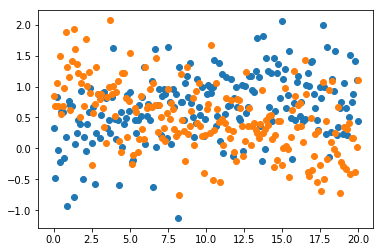

In [2]:
np.random.seed(1234)
a = 0.1
N0, N1 = 0.1, 1
npts = 200
X = np.linspace(0, 20, npts)
Y0_clean = N0 + N1*(1-np.exp(-a*X))
Y1_clean = N1*np.exp(-a*X)
Y0 = N0 + N1*(1-np.exp(-a*X)) + np.random.randn(npts)*0.5
Y1 = N1*np.exp(-a*X) + np.random.randn(npts)*0.5
plt.plot(X, Y0, "o")
plt.plot(X, Y1, "o");

In [3]:
from sympy import *
init_session(quiet=True)
alpha, N0, N1 = symbols("alpha, N0, N1", positive=True)

We have a model a we would like to find the parameters - rate $\alpha$ and initial numbers $N_0$ and $N_1$

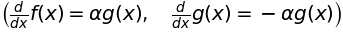

In [4]:
eqn = Eq(f(x).diff(x), alpha*g(x)), Eq(g(x).diff(x), -alpha*g(x))
eqn

The dsolve method can also calculate the integration constants if initial conditions are supplied

In [5]:
sol = dsolve(eqn, (f(x), g(x)), ics={f(0): N0, g(0): N1})
sol

Convert the solution to numerical function

In [6]:
fl = lambdify((x, N0, N1, alpha), sol[0].args[1])
gl = lambdify((x, N0, N1, alpha), sol[1].args[1])

and fit the model to our data

In [7]:
import lmfit
p0 = lmfit.Parameters()
p0.add_many(("N0", 1), ("N1", 1), ("alpha", 1))
def model(p, x):
    pval = p.valuesdict()
    r0 = fl(x, pval["N0"], pval["N1"], pval["alpha"])
    r1 = gl(x, pval["N0"], pval["N1"], pval["alpha"])
    return (r0, r1)
def residual(p, x, data):
    r0, r1 = model(p, x)
    return np.hstack((r0-data[0], r1-data[1]))
minimizer = lmfit.Minimizer(residual, p0, (X, (Y0, Y1)))
res = minimizer.leastsq()
lmfit.report_fit(res)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 39
    # data points      = 400
    # variables        = 3
    chi-square         = 93.7152421
    reduced chi-square = 0.23605854
    Akaike info crit   = -574.481481
    Bayesian info crit = -562.507087
[[Variables]]
    N0:     0.09039005 +/- 0.07641406 (84.54%) (init = 1)
    N1:     1.06458638 +/- 0.07266232 (6.83%) (init = 1)
    alpha:  0.09072997 +/- 0.01093316 (12.05%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(N0, N1)    = -0.791
    C(N0, alpha) = -0.786
    C(N1, alpha) =  0.560


The fitted values are within uncertainties equal to the true parameters, which were used to generate the data. The fit required 39 evaluations of the residual.

Lmfit was using numerical approximation of model jacobian. Can we improve it? Sympy has a method for calculating matrix jacobian

In [8]:
F = Matrix([sol[0].args[1], sol[1].args[1]])
P = Matrix([N0, N1, alpha])
J = F.jacobian(P)
J

⎡        -α⋅x        -α⋅x ⎤
⎢1  1 - ℯ      N₁⋅x⋅ℯ     ⎥
⎢                         ⎥
⎢      -α⋅x           -α⋅x⎥
⎣0    ℯ        -N₁⋅x⋅ℯ    ⎦

we convert the symbolic jacobian into numerical function suitable for `leastsq` optimization

In [9]:
ljac = [[lambdify((x, N0, N1, alpha), J[i, j]) for i in range(2)] for j in range(3)]
def Dfun(p, x, data):
    pval = p.valuesdict()
    r0 = [np.hstack((
        jel[0](x, pval["N0"], pval["N1"], pval["alpha"])*np.ones_like(x),
        jel[1](x, pval["N0"], pval["N1"], pval["alpha"])*np.ones_like(x)
    )) for jel in ljac]
    return np.array(r0).T

In [10]:
res = minimizer.leastsq(Dfun=Dfun)
lmfit.report_fit(res)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12
    # data points      = 400
    # variables        = 3
    chi-square         = 93.7152421
    reduced chi-square = 0.23605854
    Akaike info crit   = -574.481481
    Bayesian info crit = -562.507087
[[Variables]]
    N0:     0.09039004 +/- 0.07641405 (84.54%) (init = 1)
    N1:     1.06458638 +/- 0.07266232 (6.83%) (init = 1)
    alpha:  0.09072997 +/- 0.01093316 (12.05%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(N0, N1)    = -0.791
    C(N0, alpha) = -0.786
    C(N1, alpha) =  0.560


Now we needed only 12 evaluations

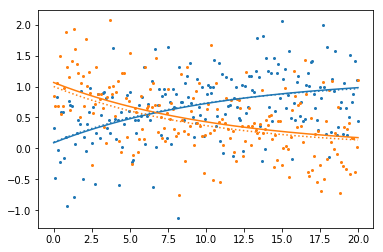

In [11]:
%matplotlib inline
plt.plot(X, Y0, "o", ms=2, label="data0")
plt.plot(X, Y1, "o", ms=2, label="data1")
plt.plot(X, model(res.params, X)[0], c="C0", label="fit0")
plt.plot(X, model(res.params, X)[1], c="C1", label="fit1")
plt.plot(X, Y0_clean, ":", c="C0", label="original0")
plt.plot(X, Y1_clean, ":", c="C1", label="original1")